In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from google.colab import drive 
drive.mount('/content/gdrive')

tf.keras.backend.clear_session()  # For easy reset of notebook state.

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My\ Drive/Public/

/content/gdrive/My Drive/Public


In [0]:
df = pd.read_csv('BBRI.JK.csv')

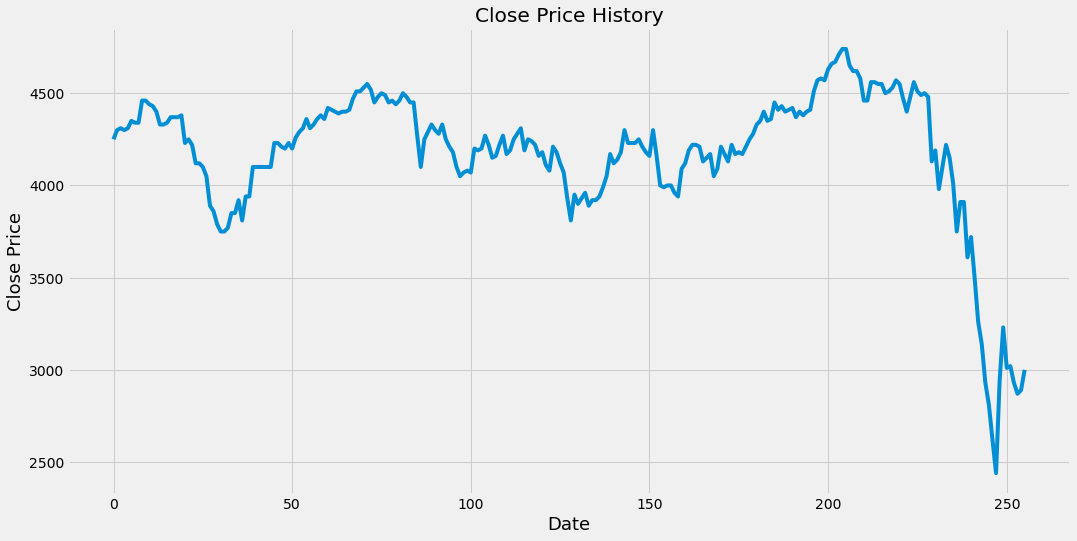

In [5]:
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price', fontsize = 18)
plt.show()

In [6]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

205

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [0]:
train_data = scaled_data[0:training_data_len,:]
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [9]:
x_train, y_train = np.array(x_train) , np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(145, 60, 1)

In [19]:
model = tf.keras.Sequential()

model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(16, return_sequences=True)))
model.add(keras.layers.Flatten())
model.add(layers.Dense(8))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer= 'adam')

model.summary()
model.fit(x_train, y_train, batch_size = 1, epochs=30)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 60, 128)           33792     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 60, 64)            41216     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 60, 32)            10368     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 15368     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 100,753
Trainable params: 100,753
Non-trainable params: 0
________________________________________________

In [20]:
test_data = scaled_data[training_data_len - 60:, :]
x_test =[]
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)) :
  x_test.append(test_data[i-60:i, 0])
  
x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0], x_train.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

81.68078852634804

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


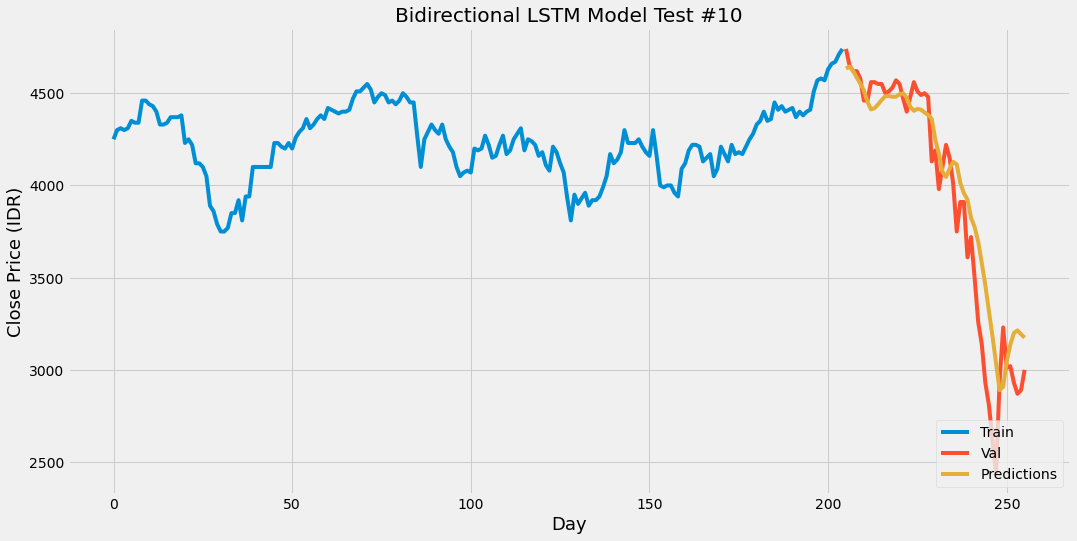

In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title("Bidirectional LSTM Model Test #10")
plt.xlabel('Day', fontsize = 18)
plt.ylabel('Close Price (IDR)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()